
### ML Training Loops for Beginners: Epochs, Batches, Batch Size & Iterations
**Goal:** Build clear intuition for four core training terms with small demos and pictures:
- **Epoch** — one full pass over the dataset.
- **Batch** — a mini-chunk of the dataset used for one update step.
- **Batch size** — how many samples are inside each batch.
- **Iteration** — one parameter update step (forward + backward/gradient update).


### Imports

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np

Batches in one epoch: [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]]
Iterations per epoch: 3


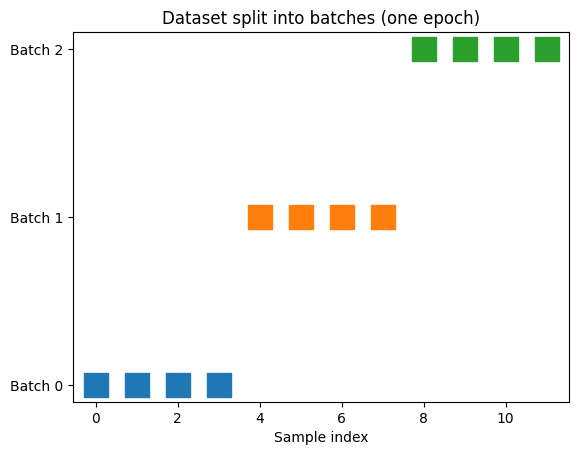

In [2]:
def make_batches(n_samples=12, batch_size=4):
    indices = list(range(n_samples))
    return [indices[i:i+batch_size] for i in range(0, n_samples, batch_size)]

batches = make_batches(n_samples=12, batch_size=4)
print("Batches in one epoch:", batches)
print("Iterations per epoch:", len(batches))

# Simple bar-like visualization of batches
plt.figure()
for i, batch in enumerate(batches):
    y = [i] * len(batch)
    x = batch
    plt.scatter(x, y, s=300, marker='s')
plt.yticks(range(len(batches)), [f"Batch {i}" for i in range(len(batches))])
plt.xlabel("Sample index")
plt.title("Dataset split into batches (one epoch)")
plt.show()



**Interpretation (plain English):**  
- The list printed shows which sample indices go together in each batch.
- The figure shows one **row per batch**. Each square is a sample index.
- **Iterations per epoch** equals the number of rows (batches).  
If you increase `batch_size`, you’ll see **fewer** batches (fewer iterations) per epoch.



### Part 2 — What is an Epoch (Looping Over Data Multiple Times)?

An **epoch** is *one full pass* over the dataset. If you train for 3 epochs,
you pass over the same data **three times**.

Below, we simulate **2 epochs** with a dataset of 10 samples and a batch size of 3.
We print which samples appear in each iteration. Notice how **each epoch** visits all samples.


In [3]:

n_samples = 10
batch_size = 3

def iterate_epochs(n_epochs=2, n_samples=10, batch_size=3):
    all_indices = list(range(n_samples))
    batches = [all_indices[i:i+batch_size] for i in range(0, n_samples, batch_size)]
    for epoch in range(1, n_epochs+1):
        print(f"\n=== Epoch {epoch} ===")
        for it, b in enumerate(batches, start=1):
            print(f"Iteration {it}: batch = {b}")

iterate_epochs(n_epochs=2, n_samples=n_samples, batch_size=batch_size)



=== Epoch 1 ===
Iteration 1: batch = [0, 1, 2]
Iteration 2: batch = [3, 4, 5]
Iteration 3: batch = [6, 7, 8]
Iteration 4: batch = [9]

=== Epoch 2 ===
Iteration 1: batch = [0, 1, 2]
Iteration 2: batch = [3, 4, 5]
Iteration 3: batch = [6, 7, 8]
Iteration 4: batch = [9]



**Interpretation:**  
- Each epoch prints all batches that together cover the dataset (from sample `0` up to the last sample).
- The last batch can be **smaller** when `n_samples` isn’t divisible by `batch_size` — that’s normal.



### Part 3 — Why Batch Size Matters (Noise vs Stability)

- **Small batch size** → more **iterations** per epoch. Each update uses fewer samples, so the gradient is **noisier** (jittery), but you get more frequent updates.
- **Large batch size** → fewer iterations per epoch. Each update uses many samples, so the gradient is **smoother** (stable), but you update **less often**.

We’ll train a tiny linear model with NumPy on synthetic data to see how **loss curves** look for different batch sizes.


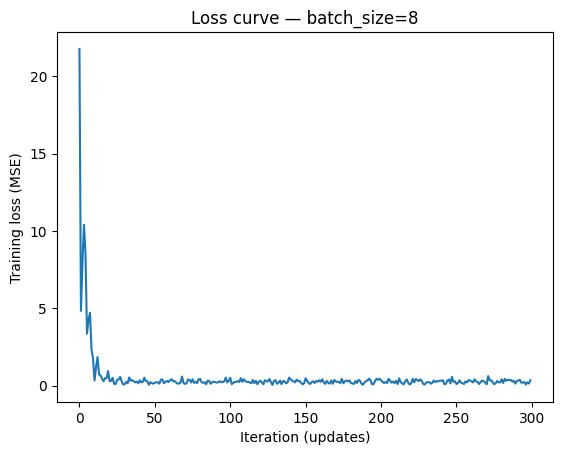

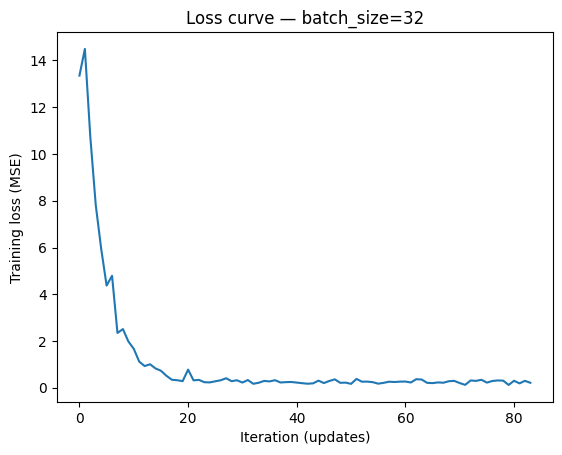

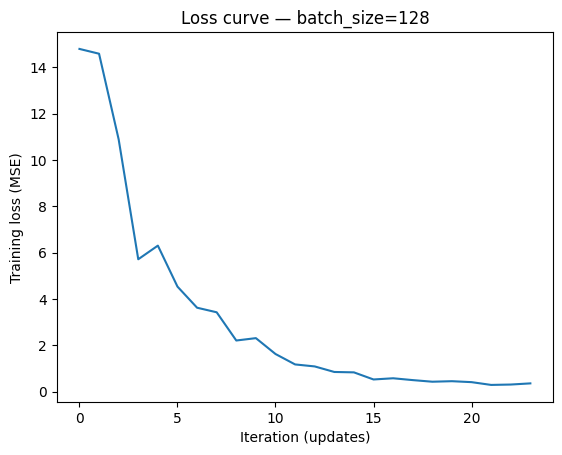

In [4]:
# Reproducibility
rng = np.random.default_rng(42)

# Synthetic linear data: y = 3x + 2 + noise
N = 200
X = rng.uniform(-2, 2, size=(N, 1))
true_w, true_b = 3.0, 2.0
y = true_w * X[:, 0] + true_b + rng.normal(0, 0.5, size=N)

def minibatch_gd(X, y, batch_size=32, epochs=20, lr=0.05):
    w = 0.0
    b = 0.0
    losses = []

    for epoch in range(epochs):
        # Shuffle each epoch
        idx = rng.permutation(len(X))
        X_shuf, y_shuf = X[idx], y[idx]

        # Iterate mini-batches
        for start in range(0, len(X_shuf), batch_size):
            end = start + batch_size
            xb = X_shuf[start:end]
            yb = y_shuf[start:end]

            # Predictions
            yhat = w * xb[:, 0] + b

            # Mean squared error and gradients
            err = yhat - yb
            loss = np.mean(err**2)
            losses.append(loss)

            # d/dw of (yhat - y)^2 is 2 * (yhat - y) * x
            dw = 2.0 * np.mean(err * xb[:, 0])
            db = 2.0 * np.mean(err)

            # Update
            w -= lr * dw
            b -= lr * db

    return losses

configs = [
    {"batch_size": 8, "epochs": 12, "lr": 0.05},
    {"batch_size": 32, "epochs": 12, "lr": 0.05},
    {"batch_size": 128, "epochs": 12, "lr": 0.05},
]

all_losses = []
labels = []
for cfg in configs:
    losses = minibatch_gd(X, y, **cfg)
    all_losses.append(losses)
    labels.append(f"batch_size={cfg['batch_size']}")

# Plot each loss curve (one figure per curve as requested)
for losses, label in zip(all_losses, labels):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Iteration (updates)")
    plt.ylabel("Training loss (MSE)")
    plt.title(f"Loss curve — {label}")
    plt.show()



**Interpretation:**  
- All curves usually go **downward** as training progresses — that’s the model learning.  
- With **smaller batch sizes**, the curve may look **noisier** (more up‑down wiggles) because each update sees fewer samples.  
- With **larger batches**, the curve often appears **smoother**, but there are **fewer total updates** per epoch.



### Part 4 — How Many Epochs? (Underfitting vs Overfitting)

- **Too few epochs** → the model hasn’t learned enough (underfitting).  
- **Too many epochs** → the model starts to memorize noise (overfitting).  

We’ll make a slightly noisy **quadratic** dataset and fit a simple model with mini‑batches.  
We’ll compare **validation loss** after training for **5 epochs** vs **50 epochs** to see the trend.


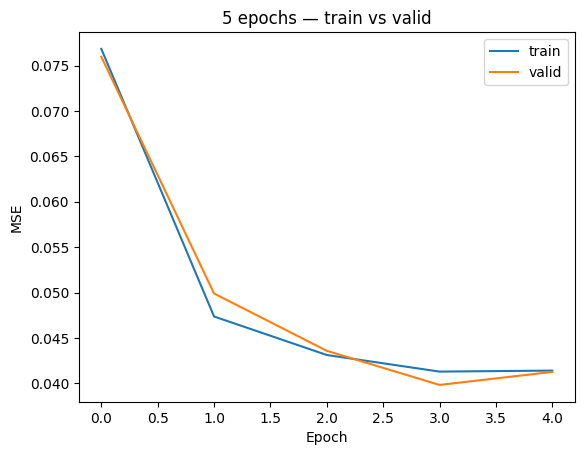

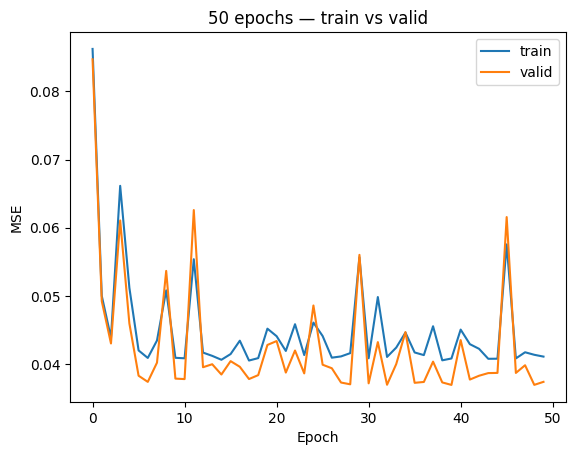

In [5]:

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

# Quadratic data: y = x^2 + noise
N = 600
X = rng.uniform(-2, 2, size=(N, 1))
y = (X[:, 0]**2) + rng.normal(0, 0.2, size=N)

# Train/valid split
idx = rng.permutation(N)
train_idx, valid_idx = idx[:450], idx[450:]
Xtr, ytr = X[train_idx], y[train_idx]
Xva, yva = X[valid_idx], y[valid_idx]

def poly_features(x):
    # [x, x^2] features for a simple quadratic model
    return np.column_stack([x[:, 0], x[:, 0]**2])

def train_minibatch(X, y, Xv, yv, epochs, batch_size=32, lr=0.05):
    W = np.zeros(2)  # weights for x and x^2
    b = 0.0

    train_losses = []
    valid_losses = []

    for ep in range(epochs):
        # Shuffle
        idx = rng.permutation(len(X))
        Xs, ys = X[idx], y[idx]

        # Batches
        for start in range(0, len(Xs), batch_size):
            end = start + batch_size
            xb_raw = Xs[start:end]
            yb = ys[start:end]
            xb = poly_features(xb_raw)

            yhat = xb @ W + b
            err = yhat - yb
            loss = np.mean(err**2)

            # grads
            dW = 2.0 * (xb.T @ err) / len(xb)
            db = 2.0 * np.mean(err)

            W -= lr * dW
            b -= lr * db

        # End of epoch: compute full train/valid losses
        XtrF = poly_features(X)
        XvaF = poly_features(Xv)
        train_losses.append(np.mean((XtrF @ W + b - y)**2))
        valid_losses.append(np.mean((XvaF @ W + b - yv)**2))

    return (train_losses, valid_losses)

short_train, short_valid = train_minibatch(Xtr, ytr, Xva, yva, epochs=5,  batch_size=32, lr=0.05)
long_train,  long_valid  = train_minibatch(Xtr, ytr, Xva, yva, epochs=50, batch_size=32, lr=0.05)

# Plot 1: Train/valid curves for 5 epochs
plt.figure()
plt.plot(short_train, label="train")
plt.plot(short_valid, label="valid")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("5 epochs — train vs valid")
plt.legend()
plt.show()

# Plot 2: Train/valid curves for 50 epochs
plt.figure()
plt.plot(long_train, label="train")
plt.plot(long_valid, label="valid")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("50 epochs — train vs valid")
plt.legend()
plt.show()



**Interpretation:**  
- With **5 epochs**, both train and validation loss may still be relatively high — the model is **undertrained**.  
- With **50 epochs**, training loss becomes lower, and validation loss may **improve** and then **flatten** or sometimes **rise** (sign of **overfitting**).  
- In practice, we watch the **validation curve** and often use **early stopping** to halt training when validation loss stops improving.



### Part 5 — Quick Math Relationships & Practical Checklist

**Math relationships:**
- `batches_per_epoch = ceil(num_samples / batch_size)`  
- `iterations_per_epoch = batches_per_epoch`  
- `total_iterations = iterations_per_epoch × num_epochs`

**Checklist to choose values:**
- If memory is tight → pick a **smaller batch size** (e.g., 16/32).  
- If training is unstable/noisy → try a **larger batch size** or **lower LR**.  
- If model underfits → increase **epochs** (and/or model capacity).  
- If model overfits → reduce **epochs**, add **regularization**, or use **early stopping**.



### Part 6 — Try Your Own Numbers

Change `num_samples`, `batch_size`, and `num_epochs` below and re‑run to see how the **counts** and **batch grouping** change.


In [6]:

import math
num_samples = 37
batch_size = 8
num_epochs = 3

batches_per_epoch = math.ceil(num_samples / batch_size)
total_iterations = batches_per_epoch * num_epochs

print(f"num_samples={num_samples}, batch_size={batch_size}, num_epochs={num_epochs}")
print(f"batches_per_epoch={batches_per_epoch}")
print(f"iterations_per_epoch={batches_per_epoch}")
print(f"total_iterations={total_iterations}")

# Show the first epoch's batch composition
def epoch_batches(n_samples, batch_size):
    arr = list(range(n_samples))
    return [arr[i:i+batch_size] for i in range(0, n_samples, batch_size)]

print("\nExample batches for one epoch:")
print(epoch_batches(num_samples, batch_size))


num_samples=37, batch_size=8, num_epochs=3
batches_per_epoch=5
iterations_per_epoch=5
total_iterations=15

Example batches for one epoch:
[[0, 1, 2, 3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15], [16, 17, 18, 19, 20, 21, 22, 23], [24, 25, 26, 27, 28, 29, 30, 31], [32, 33, 34, 35, 36]]



### Final Cheat‑Sheet (Save This!)

- **Epoch** = one full pass over the dataset.  
- **Batch** = a mini‑chunk of data used for one update.  
- **Batch size** = how many samples per batch.  
- **Iteration** = one parameter update (one batch step).  

**Rules of thumb:**  
- Smaller batch → more updates, noisier gradients.  
- Larger batch → fewer updates, smoother gradients.  
- Too few epochs → underfitting. Too many → overfitting (watch validation loss).  
- Use **early stopping** to stop when validation stops improving.
